q: [-5.5, -5.5, 0.9890000008046628]
q_px: (67, 12)
qgoal: [5.0, 5.5, 0.039000000804662704]
qgoal_px: (11, 65)


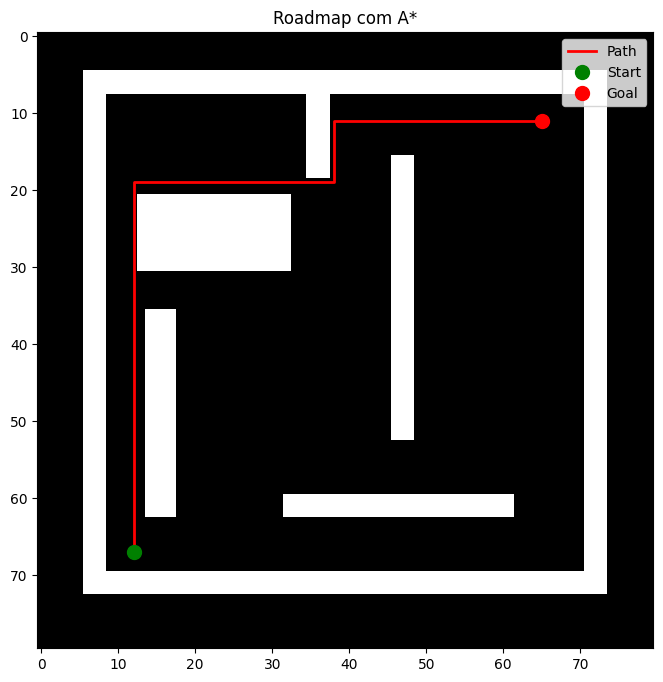

Starting robot control loop...
Simulation time: 0.10 [s]
Simulation time: 0.40 [s]
Simulation time: 0.70 [s]
Simulation time: 1.05 [s]
Simulation time: 1.35 [s]
Simulation time: 1.70 [s]
Simulation time: 2.05 [s]
Simulation time: 2.35 [s]
Simulation time: 2.75 [s]
Simulation time: 2.95 [s]
Simulation time: 3.25 [s]
Simulation time: 3.60 [s]
Simulation time: 3.85 [s]
Simulation time: 4.00 [s]
Simulation time: 4.25 [s]
Simulation time: 4.35 [s]
Simulation time: 4.60 [s]
Simulation time: 4.95 [s]
Simulation time: 5.25 [s]
Simulation time: 5.40 [s]
Simulation time: 5.70 [s]
Simulation time: 6.00 [s]
Simulation time: 6.30 [s]
Simulation time: 6.40 [s]
Simulation time: 6.75 [s]
Simulation time: 7.05 [s]
Simulation time: 7.30 [s]
Simulation time: 7.45 [s]
Simulation time: 7.55 [s]
Simulation time: 7.85 [s]
Simulation time: 8.15 [s]
Simulation time: 8.40 [s]
Simulation time: 8.70 [s]
Simulation time: 8.85 [s]
Simulation time: 9.10 [s]
Simulation time: 9.45 [s]
Simulation time: 9.75 [s]
Simulat

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

try:
    # Connect to the CoppeliaSim server
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)
    
except Exception as e:
    print(f"An error occurred: {e}")

from PIL import Image
from matplotlib.pyplot import plot

IMG_PATH = "maps/basic.png"
LARGURA_IMAGEM = 80
WORLD_ORIGIN = (-8.0, -8.0)
LARGURA_PIXEL_MUNDO = 0.2 # Valor da largura de 1px da imagem geradora do mapa em coordenadas do mundo
#Para isso, ao gerar o mapa: uma imagem 80x80px deve ser importada com x-size=12m e y-size=12m

def load_binary_mask_sem_inflate():
    img = Image.open(IMG_PATH).convert("L")
    arr = np.array(img, dtype=np.uint8)
    arr = 255 - arr
    mask = arr < 200
    return mask

def load_binary_mask():
    img = Image.open(IMG_PATH).convert("L")
    arr = np.array(img, dtype=np.uint8)
    arr = 255 - arr
    mask = arr < 200
    
    #inflar obstáculos:
    R, C = mask.shape
    inflated = mask.copy()

    # vizinhos verticais e horizontais
    inflated[1:, :]   |= mask[:-1, :]    # cima
    inflated[:-1, :]  |= mask[1:, :]     # baixo
    inflated[:, 1:]   |= mask[:, :-1]    # esquerda
    inflated[:, :-1]  |= mask[:, 1:]     # direita
    # vizinhos diagonais
    inflated[1:, 1:]    |= mask[:-1, :-1]  # cima-esquerda
    inflated[1:, :-1]   |= mask[:-1, 1:]   # cima-direita
    inflated[:-1, 1:]   |= mask[1:, :-1]   # baixo-esquerda
    inflated[:-1, :-1]  |= mask[1:, 1:]    # baixo-direita

    return inflated

def px_to_world(col_px, row_px):
    row_from_bottom = (LARGURA_IMAGEM-1) - row_px
    x = WORLD_ORIGIN[0] + ((col_px) * (LARGURA_PIXEL_MUNDO))
    y = WORLD_ORIGIN[1] + ((row_from_bottom) * (LARGURA_PIXEL_MUNDO))
    return float(x), float(y)

def world_to_px(x, y):
    col_px = round((x - WORLD_ORIGIN[0]) / LARGURA_PIXEL_MUNDO)
    row_from_bottom = round((y - WORLD_ORIGIN[1]) / LARGURA_PIXEL_MUNDO)
    row_px = (LARGURA_IMAGEM-1) - row_from_bottom
    col_px = max(0, min(LARGURA_IMAGEM-1, col_px))
    row_px = max(0, min(LARGURA_IMAGEM-1, row_px))
    return round(row_px), round(col_px)

def plot_binary_mask(mask):
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='binary')
    plt.title('Mapa Binário')
    plt.xlabel('Coluna (pixels)')
    plt.ylabel('Linha (pixels)')
    plt.show()

mask = load_binary_mask()


# Adiciona um sistema de coordenadas em cada célula do mapa que tem um obstáculo
# para visualizar no simulador se os pontos estão corretos
teste_dos_pontos_dos_obstaculos = '''
def print_mask_coordinates(mask):
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            if mask[row,col]:  # Se for True (obstáculo)
                x, y = px_to_world(col, row)
                # Adiciona um ReferenceFrame na coordenada do obstáculo
                frame_name = f"ReferenceFrame_{col}_{row}"
                frame_handle = sim.createDummy(0.1)  # Tamanho do frame = 0.1m
                sim.setObjectAlias(frame_handle, frame_name)
                sim.setObjectPosition(frame_handle, -1, [x, y, 0.01])  # z=0.01 para ficar levemente acima do chão
                #print(f"Obstáculo em: Pixel({col},{row}) -> Mundo({x:.2f},{y:.2f})")
print_mask_coordinates(mask)
'''
#plot_binary_mask(mask)

def neighbors_4(mask, node):
    R,C = mask.shape
    (row,col) = node
    candidates = [(row-1,col), (row+1,col), (row,col-1), (row,col+1)]
    result = []
    for (r,c) in candidates:
        if 0 <= r < R and 0 <= c < C and not mask[r,c]:
            result.append((r,c))
    return result

def heuristic(a, b):
    (r1,c1),(r2,c2) = a,b
    return abs(r1-r2) + abs(c1-c2) # Distância Manhattan

import heapq
def a_star(mask, start, goal):
    (R,C) = mask.shape
    pq = [] #(f,g,node,parent)
    heapq.heappush(pq, (0, 0, start, None))
    came_from = {}
    gbest = {start: 0}
    
    while pq:
        f, g, node, parent = heapq.heappop(pq)
        if node in came_from:  # já visitado com custo melhor
            continue
        came_from[node] = parent
        if node == goal:
            break
        
        for nb in neighbors_4(mask, node):
            g2 = g + 1 # custo por passo
            if nb not in gbest or g2 < gbest[nb]:
                gbest[nb] = g2
                f2 = g2 + heuristic(nb, goal)
                heapq.heappush(pq, (f2, g2, nb, node))
    
    # reconstrói caminho
    path = []
    if goal in came_from:
        cur = goal
        while cur is not None:
            path.append(cur)
            cur = came_from[cur]
        path.reverse()
    return path  # lista de (row, col) em pixels

def plot_path(mask, path):
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='gray')
    
    if path:
        path = np.array(path)
        plt.plot(path[:, 1], path[:, 0], 'r-', linewidth=2, label='Path')
        plt.plot(path[0, 1], path[0, 0], 'go', label='Start', markersize=10)
        plt.plot(path[-1, 1], path[-1, 0], 'ro', label='Goal', markersize=10)
    
    plt.legend()
    plt.title('Roadmap com A*')
    plt.show()


try:
    # Frame que representa o Goal
    goal = 'Goal'
    goalFrame = sim.getObject('/' + goal)
    
    # Handle para o ROBÔ
    robotname = 'robotino'
    robotHandle = sim.getObject('/' + robotname)
    # Handle para as juntas das RODAS
    wheel1 = sim.getObject('/' + robotname + '/wheel0_joint')
    wheel2 = sim.getObject('/' + robotname + '/wheel1_joint')
    wheel3 = sim.getObject('/' + robotname + '/wheel2_joint')
    
    # Dados Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
               
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

    # Configuração inicial (x, y, w)
    q = sim.getObjectPosition(robotHandle, sim.handle_world)
    q_orientation = sim.getObjectOrientation(robotHandle, sim.handle_world)
    q_px = world_to_px(q[0], q[1])
    print("q:",q)
    print("q_px:",q_px)

    # Posição do Goal (x, y, theta)
    qgoal = sim.getObjectPosition(goalFrame, sim.handle_world)
    qgoal_orientation = sim.getObjectOrientation(goalFrame, sim.handle_world)
    qgoal_px = world_to_px(qgoal[0], qgoal[1])
    print("qgoal:",qgoal)
    print("qgoal_px:",qgoal_px)

    path_px = a_star(mask, q_px, qgoal_px)
    # Plot the mask and path
    plot_path(mask, path_px)

    assert len(path_px) > 0, "Não foi possível encontrar um caminho"

    waypoints = []
    for i,(row,col) in enumerate(path_px):
        xw,yw = px_to_world(col,row)
        if i < len(path_px)-1:
            row2,col2 = path_px[i+1]
            x2,y2 = px_to_world(col2,row2)
            theta = np.arctan2(y2-yw, x2-xw)
        else:
            theta = qgoal_orientation[2]  # orientação final
        waypoints.append(np.array([xw,yw,theta]))

    # Lembrar de habilitar o 'Real-time mode'    
    # Parar a simulação se estiver executando
    initial_sim_state = sim.getSimulationState()
    if initial_sim_state != 0:
        sim.stopSimulation()
        time.sleep(1)
    
    # Inicia a simulação
    sim.startSimulation()
    sim.step()

    gain = np.array([[1.0, 0, 0], [0, 1.0, 0], [0, 0, 1.0]])

    i_waypoint = 0
    epsilon_xy = 0.1
    epsilon_theta = np.deg2rad(10)
    print("Starting robot control loop...")
    while (sim_time := sim.getSimulationTime()) <= 300:
        print(f"Simulation time: {sim_time:.2f} [s]")

        pos = sim.getObjectPosition(robotHandle, sim.handle_world)
        ori = sim.getObjectOrientation(robotHandle, sim.handle_world)
        q = np.array([pos[0], pos[1], ori[2]])
        # Cinemática Inversa
        # w1, w2, w3
        Minv = np.linalg.inv(Rz(q[2]) @ Mdir)

        q_proximo = waypoints[i_waypoint]
        erro = q_proximo - q

        # normalizar erro angular em (-pi,pi]
        erro[2] = (erro[2] + np.pi) % (2*np.pi) - np.pi

        if (np.linalg.norm(erro[:2]) < epsilon_xy) and (np.abs(erro[2]) < epsilon_theta):
            if i_waypoint < len(waypoints)-1:
                i_waypoint += 1
                continue
            else:
                break
        qdot = gain @ erro
        
        u = Minv @ qdot
        
        # Enviando velocidades
        sim.setJointTargetVelocity(wheel1, u[0])
        sim.setJointTargetVelocity(wheel2, u[1])
        sim.setJointTargetVelocity(wheel3, u[2]) 
                
        sim.step()

    # Parando o robô
    print("Stopping robot...")
    sim.setJointTargetVelocity(wheel1, 0)
    sim.setJointTargetVelocity(wheel2, 0)
    sim.setJointTargetVelocity(wheel3, 0)
    
    print('CALC Pos: ', sim_time, q[:2], np.rad2deg(q[2]))
      
    pos = sim.getObjectPosition(robotHandle, sim.handle_world)
    print('SIM Pos: ', pos)

    ori = sim.getObjectOrientation(robotHandle, sim.handle_world)
    print('SIM Ori: ', np.rad2deg(ori))
    

except Exception as e:
    print(f"An error occurred: {e}")

# Parando a simulação
sim.stopSimulation()
print('Program ended')